In [1]:
import bisect
import pickle
from typing import List
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio.Seq import Seq
from scipy.fft import rfft, rfftfreq
from sklearn import tree
from sklearn.model_selection import train_test_split
import transformation_utils as tfu
import io_utils as iou
import model

### Preparing Data

#### Datasets

In [2]:
# m_path_loc = "..\dataset-plek\Dados\Human\human_rna_fna_refseq_mRNA_22389"
# nc_path_loc = "..\dataset-plek\Dados\Human\human_gencode_v17_lncRNA_22389"

# m_path_loc = "..\dataset-plek\Macaca_mulatta\sequencia1.txt"
# nc_path_loc = "..\dataset-plek\Macaca_mulatta\sequencia2.txt"

m_path_loc = "..\dataset-plek\Gorilla_gorilla\sequencia2.txt"
nc_path_loc = "..\dataset-plek\Gorilla_gorilla\sequencia1.txt"

#### Loading and transforming data

In [4]:
# mRNA data
Mx, My = handle_data(m_path_loc, "mRNA")
# ncRNA data
NCx,NCy = handle_data(nc_path_loc, "ncRNA")

C:\Users\febue\AppData\Roaming\Python\Python38\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [7]:
X = [*Mx,*NCx]

min_val = len(min(X,key=len))
print(f'Tamanho da Menor Sequencia: {min_val}')

size_ls = [i for i in range(min_val)]

dfts:List[List[float]] = []
for eiip_seq in X:
    dfts.append([fft for fft, freqs in zip(eiip_seq,size_ls)])

print(len(dfts))
print(len([*My,*NCy]))

df = pd.DataFrame({'sequences': dfts, 
                    'labels': [*My,*NCy]})

X = df['sequences'].to_list()
Y = df['labels'].to_list()

df


Tamanho da Menor Sequencia: 31
33392
33392


sequences labels
0      [0.019238644448234577, 0.02782583885825606, 0....   mRNA
1      [0.031488588586400024, 0.03127635549626076, 0....   mRNA
2      [0.02535163068835451, 0.025977585125226233, 0....   mRNA
3      [0.026196775925254916, 0.04132923423418241, 0....   mRNA
4      [0.012338267468590253, 0.012071404517860361, 0...   mRNA
...                                                  ...    ...
33387  [0.020397691326637303, 0.00999503901314068, 0....  ncRNA
33388  [0.0520063564779075, 0.02694608568127411, 0.08...  ncRNA
33389  [0.0371500017254037, 0.07367361093476892, 0.04...  ncRNA
33390  [0.027240232523057472, 0.05716865716868545, 0....  ncRNA
33391  [0.03221016215305307, 0.018219657594302004, 0....  ncRNA

[33392 rows x 2 columns]

### Training Model

In [40]:
filename = "rrna_decisiontree.pickle"

classification_model = model.model(X=X, Y=Y)

# save model
pickle.dump(classification_model, open(filename, "wb"))

[0.97364743 0.97534438 0.97684168 0.97574366 0.97684168 0.9754442
 0.974446   0.97664204 0.9759433  0.97474546]
Fold 2:
  Train: index=[ 3772 19713 28926 ...  4742 12598 10792]
Fold 4:
  Train: index=[ 4120 31828 26907 ... 20956 33288 33216]


#### Load Decision Tree Fitted Model

In [41]:
filename = "rrna_decisiontree.pickle"
loaded_model = pickle.load(open(filename, "rb"))

In [45]:
plt.figure(figsize=(200,100), dpi=80)
class_names = loaded_model.classes_
tree.plot_tree(loaded_model, fontsize=14, class_names=class_names)
plt.savefig('foo.png')

##### Extract the most importants features

In [6]:
# Get feature importances
threshold = 0.0  # Adjust as needed
importances = loaded_model.feature_importances_

importances =list(filter(lambda x: x > threshold, importances)) 

importances


[0.3979788489782914,
 0.06718756203687734,
 0.0037195919570881084,
 0.006348385081675303,
 0.003347781195414711,
 0.005318802422267268,
 0.018547123652746578,
 0.01606246402201995,
 0.0035857700839494262,
 0.009017592445561506,
 0.006751685778866241,
 0.003471773091541182,
 0.022165232398568376,
 0.012399189612647073,
 0.007661485273940526,
 0.003409777143477946,
 0.003533769039604415,
 0.007725648912495487,
 0.0034336217388868805,
 0.02517653876547633,
 0.00011574855718311227,
 0.0036035144811755555,
 0.009832084666450932,
 0.009468472067839583,
 0.01872022354076506,
 0.0068743939333073,
 0.011914799753388652,
 0.003581794853708404,
 0.010534542251668227,
 0.003636064472703978,
 0.009592463963966055,
 0.007010560432639327,
 0.002975805507035297,
 0.0035709666084423565,
 0.009132768717111953,
 0.02122574633763061,
 0.028871077971871655,
 0.006090190192094298,
 0.008975322480972938,
 0.0024798379225294148,
 0.0041776245325630375,
 0.004678939476470591,
 0.025344074933554075,
 0.01038656

### Cross-Spectrum Bins

In [29]:
mrnas_zip:List[List[float]] = []
ncrnas_zip:List[List[float]] = []

for eiip_seq in Mx:
    # norm_seq = iou.min_max_norm(eiip_seq)
    mrnas_zip.append([fft for fft, freqs in zip(eiip_seq,size_ls)])

for eiip_seq in NCx:
    # norm_seq = iou.min_max_norm(eiip_seq)
    ncrnas_zip.append([fft for fft, freqs in zip(eiip_seq,size_ls)])

In [30]:
#mRNA zero elements
mdiscrimated_idx:List[int] = []
for seq_i in range(len(mrnas_zip)):
    for i in range(len(mrnas_zip[seq_i])):
        if(mrnas_zip[seq_i][i] == 0.0000000000):
            # print(f'seq: {seq_i}, inidice: {i}')
            if(i not in mdiscrimated_idx):
                mdiscrimated_idx.append(i)

mdiscrimated_idx.sort()
print(mdiscrimated_idx)

[]


In [31]:
#ncRNA zero elements
ncdiscrimated_idx:List[int] = []
for seq_i in range(len(ncrnas_zip)):
    for i in range(len(ncrnas_zip[seq_i])):
        if(ncrnas_zip[seq_i][i] == 0.0000000000):
            # print(f'seq: {seq_i}, inidice: {i}')
            if(i not in ncdiscrimated_idx):
                ncdiscrimated_idx.append(i)

ncdiscrimated_idx.sort()
print(ncdiscrimated_idx)

[]


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


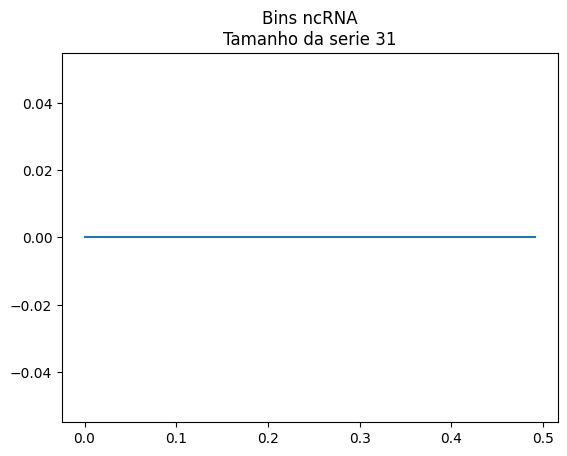

In [16]:
nc_bins = collect_bins(sequences=ncrnas_zip,
                       seq_size=min_val,
                       class_name="ncRNA")

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


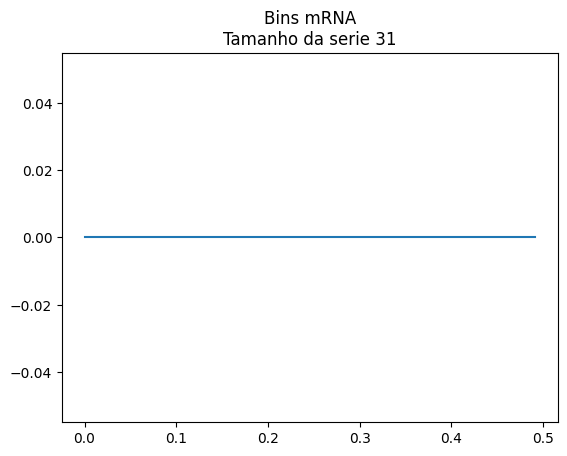

In [17]:
m_bins = collect_bins(sequences=mrnas_zip,
                       seq_size=min_val,
                       class_name="mRNA")